# WK05: Databases Exercises - Part 3

Using SQLAlchemy to interact with the database.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The file "stackoverflow.db" is a sqlite3 database file. It contains the following eight tables:
- Badges
- Users
- Comments
- Tags
- PostHistory
- PostLinks
- Posts
- Votes
```
table_names = ['comments', 'users', 'votes', 'tags', 'posthistory', 'postlinks', 'posts', 'badges']
```

## Exercise 1

The previous join showed us the top 5 users that have the most badges. For exercise 1, you will create a dataframe that will allow us to find the badges that have been assigned to the most users and the average reputation of those users.



a) Write a sql query that returns the amount of users that have each badge and the average reputation of those users, order by the number of users.  

In [57]:
import pandas as pd
from sqlalchemy import create_engine, text


engine = create_engine('sqlite:///stackoverflow.db')

query = '''
SELECT b.Name, COUNT(DISTINCT b.UserId) AS num_users, AVG(u.Reputation) AS avg_reputation
FROM badges b
JOIN users u ON b.UserId = u.Id
GROUP BY b.Name
ORDER BY num_users DESC;
'''

b) Run that query with `pd.read_sql_query` and show the top 5 rows.  


In [58]:
with engine.connect() as conn:
    df = pd.read_sql_query(text(query), con=conn)
df.head(5)

,Name,num_users,avg_reputation
0,Autobiographer,35061,89.562135
1,Supporter,19401,162.816143
2,Student,15624,122.593958
3,Editor,10653,172.035483
4,Informed,8078,110.911736


c) Recreate that query using the SQLAlchemy methods and print out the statement.  


In [59]:
from sqlalchemy import Table, MetaData
from sqlalchemy import func, desc
from sqlalchemy import select

metadata = MetaData()
user_table = Table("users", metadata, autoload_with=engine)
badges_table = Table("badges", metadata, autoload_with=engine)

stmt = select(badges_table.c.Name, func.count(badges_table.c.UserId).label("num_users"), func.avg(user_table.c.Reputation).label("avg_reputation")).\
    join(badges_table, user_table.c.Id == badges_table.c.UserId).\
    group_by(badges_table.c.Name).\
    order_by(desc("num_users"))

print(stmt)

SELECT badges."Name", count(badges."UserId") AS num_users, avg(users."Reputation") AS avg_reputation 
FROM users JOIN badges ON users."Id" = badges."UserId" GROUP BY badges."Name" ORDER BY num_users DESC


d) Run that query again with `pd.read_sql_query` and show the top 5 rows again. It should be showing the same info as in `b`, is it?  

In [60]:
with engine.connect() as conn:
    df = pd.read_sql_query(stmt, con=conn)

df.head(5)

,Name,num_users,avg_reputation
0,Autobiographer,35061,89.562135
1,Supporter,19401,162.816143
2,Student,15624,122.593958
3,Editor,10653,172.035483
4,Informed,8078,110.911736


## Exercise 2

For exercise 2, you will need to be able to look at the Data Dictionary for the StackExchange data dump. That can be found here:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede/2678#2678


a) Create a DataFrame that shows how many Questions a user has posted, the average score of those questions, and the user's reputation. Sort by the numer of questions posted so that `head()` will show the top 5 users that have asked the most questions.

In [61]:
engine = create_engine('sqlite:///stackoverflow.db')

query = '''
SELECT u.Id, COUNT(p.Id) AS num_questions, AVG(p.Score) AS avg_score, u.Reputation
FROM Users u
JOIN Posts p ON u.Id = p.OwnerUserId
WHERE p.PostTypeId = 1
GROUP BY u.Id, u.Reputation
ORDER BY num_questions DESC
'''

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), con=conn)
df.head(5)

,Id,num_questions,avg_score,Reputation
0,64876,140,1.471429,2387
1,8820,101,14.514851,18040
2,43077,66,3.378788,2626
3,84229,60,1.266667,771
4,21560,56,14.160714,8137


b) Create a similar DataFrame, but instead of Questions we want to look at Answers.  


In [62]:
engine = create_engine('sqlite:///stackoverflow.db')

query = '''
SELECT u.Id, p.OwnerDisplayName, COUNT(p.Id) AS num_answers, AVG(p.Score) AS avg_score, u.Reputation
FROM Users u
JOIN Posts p ON u.Id = p.OwnerUserId
WHERE p.PostTypeId = 2
GROUP BY u.Id, u.Reputation
ORDER BY num_answers DESC
'''

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), con=conn)
df.head(5)

,Id,OwnerDisplayName,num_answers,avg_score,Reputation
0,1330,None,1382,0.852388,18029
1,64377,None,1259,1.258141,23805
2,14675,None,486,2.419753,16870
3,836,None,443,5.013544,27713
4,45264,None,436,2.486239,14243


c) Create a dataframe that combines those results so that it contains name, reputation, average post score, average question score, and the number of questions they have posted, and the number of answers they have posted.  

In [63]:
engine = create_engine('sqlite:///stackoverflow.db')

query = '''
SELECT u.Id, p.OwnerDisplayName AS Name, u.Reputation, 
    COUNT(CASE WHEN p.PostTypeId = 1 THEN p.Id END) AS NumQuestions, 
    AVG(CASE WHEN p.PostTypeId = 1 THEN p.Score END) AS AvgQuestionScore,
    COUNT(CASE WHEN p.PostTypeId = 2 THEN p.Id END) AS NumAnswers, 
    AVG(CASE WHEN p.PostTypeId = 2 THEN p.Score END) AS AvgAnswerScore
FROM posts p
JOIN users u ON p.OwnerUserId = u.Id
GROUP BY u.Id, u.Reputation
ORDER BY u.Reputation DESC;
'''

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), con=conn)
df.head(5)

,Id,Name,Reputation,NumQuestions,AvgQuestionScore,NumAnswers,AvgAnswerScore
0,836,None,27713,6,18.500000,443,5.013544
1,64377,None,23805,1,0.000000,1259,1.258141
2,8820,None,18040,101,14.514851,108,4.000000
3,1330,None,18029,5,5.800000,1382,0.852388
4,14675,None,16870,2,21.000000,486,2.419753


d) Plot the data to reveal any relationship that exists between reputation, average post/question score, and the number of questions/answers they have posted. 

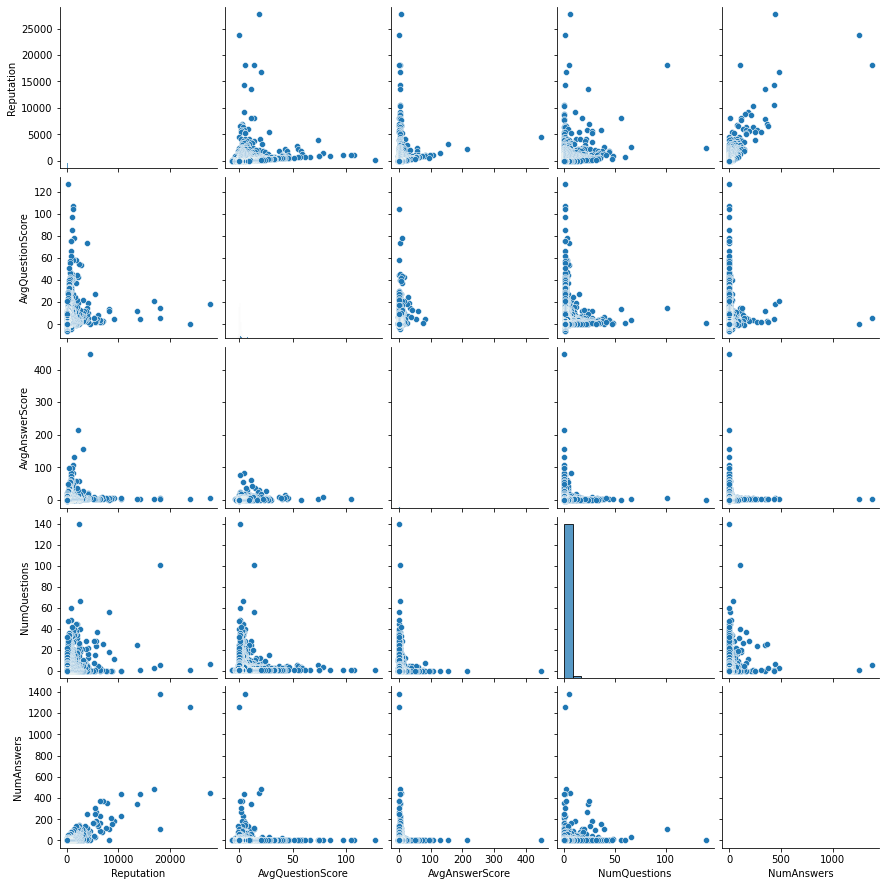

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df, vars=['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'NumQuestions', 'NumAnswers'])
plt.show()

e) Explain what you see. If you want to rapidly gain reputation, would it be better to ask a lot of questions or post a lot of answers? Should you go for volume or quantity?

When observing the scatterplot matrix plot, no noticeable change is observed in the relationship between the quantity of question and the amount of the user's reputation or answers they have posted.
Moreover, it is considered that there is no relationship between the question or answer average score and the quantity of posts.When it analyze this comprehensively, we show that focusing more on quality than the quantity of contribution to achieve fame quickly can have a faster effect.

f) Find additional data that is helpful in trying to understand the user behaviors that lead to having higher reputation and create a visualization that makes use of that new data. Explain what the visualization is showing.

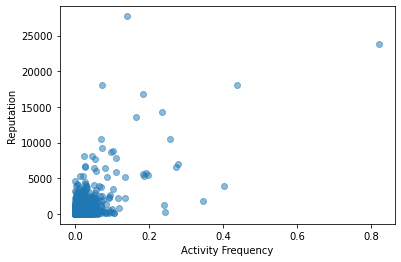

In [65]:
engine = create_engine('sqlite:///stackoverflow.db')

query = '''
SELECT u.Id AS UserId, u.Reputation, u.CreationDate, 
        COUNT(CASE WHEN p.PostTypeId = 1 THEN p.Id END) AS NumQuestions, 
        COUNT(CASE WHEN p.PostTypeId = 2 THEN p.Id END) AS NumAnswers
    FROM posts p
    JOIN users u ON p.OwnerUserId = u.Id
    GROUP BY u.Id, u.Reputation, u.CreationDate
'''

with engine.connect() as conn:
    df = pd.read_sql_query(text(query), con=conn)

df['DaysSinceJoin'] = (pd.to_datetime('2023-02-27') - pd.to_datetime(df['CreationDate'])).dt.days
df['ActivityFrequency'] = (df['NumQuestions'] + df['NumAnswers']) / df['DaysSinceJoin']

plt.scatter(df['ActivityFrequency'], df['Reputation'], alpha=0.5)
plt.xlabel('Activity Frequency')
plt.ylabel('Reputation')
plt.show()

Have positive correlation between activity frequency and reputation is considered to exist.People with a high reputation are inactive, while people with a low reputation are active. This indicates that most users of the data are short-term rather than actively responding to the knowledge base of the community.This data provides observations of Stack Overflow patterns.